### LOADING PREPROCESSED DATA

Loading GloVe word embeddings. Building functions to convert words into their vector representations and vice versa. Loading babi induction task 10K dataset.

In [1]:
import numpy as np
from __future__ import division

filename = 'glove.6B.100d.txt'

def loadEmbeddings(filename):
    vocab = []
    embd = []
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded!')
    file.close()
    return vocab,embd
vocab,embd = loadEmbeddings(filename)


word_vec_dim = len(embd[0])

vocab.append('<UNK>')
embd.append(np.asarray(embd[vocab.index('unk')],np.float32)+0.01)

vocab.append('<EOS>')
embd.append(np.asarray(embd[vocab.index('eos')],np.float32)+0.01)

vocab.append('<PAD>')
embd.append(np.zeros((word_vec_dim),np.float32))

embedding = np.asarray(embd)
embedding = embedding.astype(np.float32)

def word2vec(word):  # converts a given word into its vector representation
    if word in vocab:
        return embedding[vocab.index(word)]
    else:
        return embedding[vocab.index('<UNK>')]

def most_similar_eucli(x):
    xminusy = np.subtract(embedding,x)
    sq_xminusy = np.square(xminusy)
    sum_sq_xminusy = np.sum(sq_xminusy,1)
    eucli_dists = np.sqrt(sum_sq_xminusy)
    return np.argsort(eucli_dists)

def vec2word(vec):   # converts a given vector representation into the represented word 
    most_similars = most_similar_eucli(np.asarray(vec,np.float32))
    return vocab[most_similars[0]]

import pickle

with open ('embeddingPICKLE', 'rb') as fp:
    processed_data = pickle.load(fp)

fact_stories = processed_data[0]
questions = processed_data[1]
answers = np.reshape(processed_data[2],(len(processed_data[2])))
test_fact_stories = processed_data[3]
test_questions = processed_data[4]
test_answers = np.reshape(processed_data[5],(len(processed_data[5])))

Loaded!


In [2]:
import random

print "EXAMPLE DATA:\n"

sample = random.randint(0,len(fact_stories))

print "FACTS:\n"
for i in xrange(len(fact_stories[sample])):
    print str(i+1)+") ",
    print map(vec2word,fact_stories[sample][i])
    
print "\nQUESTION:"
print map(vec2word,questions[sample])
print "\nANSWER:"
print vocab[answers[sample]]

EXAMPLE DATA:

FACTS:

1)  ['julius', 'is', 'a', 'swan']
2)  ['greg', 'is', 'a', 'rhino']
3)  ['brian', 'is', 'a', 'frog']
4)  ['julius', 'is', 'white', '<PAD>']
5)  ['lily', 'is', 'a', 'rhino']
6)  ['lily', 'is', 'yellow', '<PAD>']
7)  ['greg', 'is', 'yellow', '<PAD>']
8)  ['bernhard', 'is', 'a', 'frog']
9)  ['brian', 'is', 'green', '<PAD>']

QUESTION:
['what', 'color', 'is', 'bernhard']

ANSWER:
green


### CREATING TRAINING AND VALIDATION DATA

In [3]:
from __future__ import division

train_fact_stories = []
train_questions = []
train_answers = []
val_fact_stories = []
val_questions = []
val_answers = []

p=90 #(90% data used for training. Rest for validation)
    
train_len = int((p/100)*len(fact_stories))

train_fact_stories = fact_stories[0:train_len] 
val_fact_stories = fact_stories[train_len:]

train_questions = questions[0:train_len] 
val_questions = questions[train_len:] 

train_answers = answers[0:train_len] 
val_answers = answers[train_len:] 



### SENTENCE READING LAYER IMPLEMENTED BEFOREHAND 

Positionally encode the word vectors in each sentence, and combine all the words in the sentence to create a fixed sized vector representation for the sentence.

"sentence embedding"

In [4]:
# from __future__ import division

def sentence_reader(fact_stories): #positional_encoder
    
    PAD_val = np.zeros((word_vec_dim),np.float32)
    
    pe_fact_stories = np.zeros((fact_stories.shape[0],fact_stories.shape[1],word_vec_dim),np.float32)
    
    for fact_story_index in xrange(0,len(fact_stories)):
        for fact_index in xrange(0,len(fact_stories[fact_story_index])):
            
            M = 0
            
            # Code to ignore pads. 
            for word_position in xrange(len(fact_stories[fact_story_index,fact_index])):
                if np.all(np.equal(PAD_val,fact_stories[fact_story_index,fact_index,word_position])):
                    break
                else:
                    M+=1
                
            l = np.zeros((word_vec_dim),np.float32) 
            
            # ljd = (1 − j/M) − (d/D)(1 − 2j/M),
            
            for word_position in xrange(0,M):
                
                for dimension in xrange(0,word_vec_dim):
                    
                    j = word_position + 1 # making position start from 1 instead of 0
                    d = dimension + 1 # making dimensions start from 1 isntead of 0 (1-100 instead of 0-99)
                    
                    l[dimension] = (1-(j/M)) - (d/word_vec_dim)*(1-2*(j/M))
 
                
                pe_fact_stories[fact_story_index,fact_index] += np.multiply(l,fact_stories[fact_story_index,fact_index,word_position])


    return pe_fact_stories

train_fact_stories = sentence_reader(train_fact_stories)
val_fact_stories = sentence_reader(val_fact_stories)
test_fact_stories = sentence_reader(test_fact_stories)
                
        

### Function to create randomized batches

In [5]:
def create_batches(fact_stories,questions,answers,batch_size):
    
    shuffle = np.arange(len(questions))
    np.random.shuffle(shuffle)
    
    batches_fact_stories = []
    batches_questions = []
    batches_answers = []
    
    i=0
    
    while i+batch_size<=len(questions):
        batch_fact_stories = []
        batch_questions = []
        batch_answers = []
        
        for j in xrange(i,i+batch_size):
            batch_fact_stories.append(fact_stories[shuffle[j]])
            batch_questions.append(questions[shuffle[j]])
            batch_answers.append(answers[shuffle[j]])
            
        batch_fact_stories = np.asarray(batch_fact_stories,np.float32)
        batch_fact_stories = np.transpose(batch_fact_stories,[1,0,2])
        #result = number of facts x batch_size x fact sentence size x word vector size
        
        batch_questions = np.asarray(batch_questions,np.float32)
        batch_questions = np.transpose(batch_questions,[1,0,2])
        #result = question_length x batch_size x fact sentence size x word vector size
        
        batches_fact_stories.append(batch_fact_stories)
        batches_questions.append(batch_questions)
        batches_answers.append(batch_answers)
        
        i+=batch_size
        
    batches_fact_stories = np.asarray(batches_fact_stories,np.float32)
    batches_questions = np.asarray(batches_questions,np.float32)
    batches_answers = np.asarray(batches_answers,np.int32)
    
    return batches_fact_stories,batches_questions,batches_answers
    


### Hyperparameters

In [6]:
import tensorflow as tf

# Tensorflow placeholders

tf_facts = tf.placeholder(tf.float32,[None,None,word_vec_dim])
tf_questions = tf.placeholder(tf.float32,[None,None,word_vec_dim])
tf_answers = tf.placeholder(tf.int32,[None])
training = tf.placeholder(tf.bool)

#hyperparameters
epochs = 256
learning_rate = 0.001
hidden_size = 100
passes = 3
dropout_rate = 0.1
beta = 0.0001 #l2 regularization scale

regularizer = tf.contrib.layers.l2_regularizer(scale=beta) #l2


### All the trainable parameters initialized here

In [7]:
# Parameters

# FORWARD GRU PARAMETERS FOR INPUT MODULE

wf = tf.get_variable("wf", shape=[3,word_vec_dim, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer= regularizer)
uf = tf.get_variable("uf", shape=[3,hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
bf = tf.get_variable("bf", shape=[3,hidden_size],initializer=tf.zeros_initializer())


# BACKWARD GRU PARAMETERS FOR INPUT MODULE

wb = tf.get_variable("wb", shape=[3,word_vec_dim, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
ub = tf.get_variable("ub", shape=[3,hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
bb = tf.get_variable("bb", shape=[3,hidden_size],initializer=tf.zeros_initializer())

# GRU PARAMETERS FOR QUESTION MODULE (TO ENCODE THE QUESTIONS)

wq = tf.get_variable("wq", shape=[3,word_vec_dim, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
uq = tf.get_variable("uq", shape=[3,hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                      regularizer=regularizer)
bq = tf.get_variable("bq", shape=[3,hidden_size],initializer=tf.zeros_initializer())


# EPISODIC MEMORY

# ATTENTION MECHANISM

inter_neurons = hidden_size

w1 = tf.get_variable("w1", shape=[hidden_size*4, inter_neurons],
                     initializer=tf.contrib.layers.xavier_initializer(),
                     regularizer=regularizer)
b1 = tf.get_variable("b1", shape=[inter_neurons],
                     initializer=tf.zeros_initializer())
w2 = tf.get_variable("w2", shape=[inter_neurons,1],
                     initializer=tf.contrib.layers.xavier_initializer(),
                     regularizer=regularizer)
b2 = tf.get_variable("b2", shape=[1],initializer=tf.zeros_initializer())


# ATTENTION BASED GRU PARAMETERS

watt = tf.get_variable("watt", shape=[2,hidden_size,hidden_size],
                       initializer=tf.contrib.layers.xavier_initializer(),
                       regularizer=regularizer)
uatt = tf.get_variable("uatt", shape=[2,hidden_size, hidden_size],
                      initializer=tf.contrib.layers.xavier_initializer(),
                       regularizer=regularizer)
batt = tf.get_variable("batt", shape=[2,hidden_size],initializer=tf.zeros_initializer())


# MEMORY UPDATE PARAMETERS
# (UNTIED)

wt = tf.get_variable("wt", shape=[passes,hidden_size*3,hidden_size],
                    initializer=tf.contrib.layers.xavier_initializer(),
                    regularizer=regularizer)
bt = tf.get_variable("bt", shape=[passes,hidden_size],
                     initializer=tf.zeros_initializer())

# ANSWER MODULE PARAMETERS

wa_pd = tf.get_variable("wa_pd", shape=[hidden_size*2,len(vocab)],
                     initializer=tf.contrib.layers.xavier_initializer(),
                     regularizer=regularizer)
ba_pd = tf.get_variable("ba_pd", shape=[len(vocab)],
                     initializer=tf.zeros_initializer())


### Layer Normalization

In [8]:

def layer_norm(inputs,scope,scale=True,layer_norm=True,epsilon = 1e-5):
    
    if layer_norm == True:
        
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            
            if scale == False:
                scale = tf.ones([inputs.get_shape()[1]],tf.float32)
            else:
                scale = tf.get_variable("scale", shape=[inputs.get_shape()[1]],
                        initializer=tf.ones_initializer())
        
        
        ## ignored shift - bias will be externally added which can produce shift

        mean, var = tf.nn.moments(inputs, [1], keep_dims=True)
        
        LN = tf.multiply((scale / tf.sqrt(var + epsilon)),(inputs - mean))
        
        return LN
    else:
        return inputs

###  GRU Function

Returns a tensor of all the hidden states

In [9]:
def GRU(inp,hidden,
        w,u,b,
        seq_len,scope):

    hidden_lists = tf.TensorArray(size=seq_len,dtype=tf.float32)
    
    i=0
    
    def cond(i,hidden,hidden_lists):
        return i < seq_len
    
    def body(i,hidden,hidden_lists):
        
        x = inp[i]
 
        # GRU EQUATIONS:
        z = tf.sigmoid(layer_norm( tf.matmul(x,w[0]) + tf.matmul(hidden,u[0]) , scope+"_z")+ b[0])
        r = tf.sigmoid(layer_norm( tf.matmul(x,w[1]) + tf.matmul(hidden,u[1]) , scope+"_r")+ b[1])
        h_ = tf.tanh(layer_norm( tf.matmul(x,w[2]) + tf.multiply(r,tf.matmul(hidden,u[2])),scope+"_h") + b[2])
        hidden = tf.multiply(z,h_) + tf.multiply((1-z),hidden)

        hidden_lists = hidden_lists.write(i,hidden)
        
        return i+1,hidden,hidden_lists
    
    _,_,hidden_lists = tf.while_loop(cond,body,[i,hidden,hidden_lists])
    
    return hidden_lists.stack()
        

### Attention based GRU

Returns only the final hidden state.

In [10]:
def attention_based_GRU(inp,hidden,
                        w,u,b,
                        g,seq_len,scope):
    
    i=0
    
    def cond(i,hidden):
        return i < seq_len
    
    def body(i,hidden):
        
        x = inp[i]

        # GRU EQUATIONS:
        r = tf.sigmoid(layer_norm( tf.matmul(x,w[0]) + tf.matmul(hidden,u[0]), scope+"_r") + b[0])
        h_ = tf.tanh(layer_norm( tf.matmul(x,w[1]) + tf.multiply(r,tf.matmul(hidden,u[1])),scope+"_h") + b[1])
        hidden = tf.multiply(g[i],h_) + tf.multiply((1-g[i]),hidden)
        
        return i+1,hidden
    
    _,hidden = tf.while_loop(cond,body,[i,hidden])
    
    return hidden

### Dynamic Memory Network+ Model Definition

In [11]:
def DMN_plus(tf_facts,tf_questions):
    
    facts_num = tf.shape(tf_facts)[0]
    tf_batch_size = tf.shape(tf_questions)[1]
    question_len = tf.shape(tf_questions)[0]
    
    hidden = tf.zeros([tf_batch_size,hidden_size],tf.float32)

    # Input Module

    # input fusion layer 
    # bidirectional GRU
    
    forward = GRU(tf_facts,hidden,
                  wf,uf,bf,
                  facts_num,"Forward_GRU")
    
    backward = GRU(tf.reverse(tf_facts,[0]),hidden,
                   wb,ub,bb,
                   facts_num,"Backward_GRU")
    
    backward = tf.reverse(backward,[0])
    
    encoded_input = tf.add(forward,backward)
    
    # encoded input now shape = facts_num x batch_size x hidden_size
    
    encoded_input = tf.layers.dropout(encoded_input,dropout_rate,training=training)

    # Question Module
    
    question_representation = GRU(tf_questions,hidden,
                                  wq,uq,bq,
                                  question_len,"Question_GRU")
    
    #question_representation's current shape = question len x batch size x hidden size
    
    question_representation = question_representation[question_len-1]
    
    #^we will only use the final hidden state. 

    question_representation = tf.reshape(question_representation,[tf_batch_size,1,hidden_size])
    
    # Episodic Memory Module
    
    episodic_memory = tf.identity(question_representation)
    
    encoded_input = tf.transpose(encoded_input,[1,0,2])
    #now shape = batch_size x facts_num x hidden_size
    

    for i in xrange(passes):
        
        # Attention Mechanism
        
        Z1 = tf.multiply(encoded_input,question_representation)
        Z2 = tf.multiply(encoded_input,episodic_memory)
        Z3 = tf.abs(tf.subtract(encoded_input,question_representation))
        Z4 = tf.abs(tf.subtract(encoded_input,episodic_memory))
        
        Z = tf.concat([Z1,Z2,Z3,Z4],2)
        
        Z = tf.reshape(Z,[-1,4*hidden_size])
        Z = tf.matmul( tf.tanh( layer_norm( tf.matmul(Z,w1), "Attention_Mechanism") + b1),w2 ) 
        Z = layer_norm(Z,"Attention_Mechanism_2") + b2
        Z = tf.reshape(Z,[tf_batch_size,1,facts_num])
        
        g = tf.nn.softmax(Z)

        g = tf.transpose(g,[2,0,1])
        
        context_vector = attention_based_GRU(tf.transpose(encoded_input,[1,0,2]),
                                             hidden,
                                             watt,uatt,batt,
                                             g,facts_num,"Attention_GRU")
                                             
        
        context_vector = tf.reshape(context_vector,[tf_batch_size,1,hidden_size])
        
        # Episodic Memory Update
        
        concated = tf.concat([episodic_memory,context_vector,question_representation],2)
        concated = tf.reshape(concated,[-1,3*hidden_size])
        
        episodic_memory = tf.nn.relu(layer_norm(tf.matmul(concated,wt[i]),"Memory_Update",scale=False) + bt[i])
        
        episodic_memory = tf.reshape(episodic_memory,[tf_batch_size,1,hidden_size])

    # Answer module 
    
    # (single word answer prediction)

    episodic_memory = tf.reshape(episodic_memory,[tf_batch_size,hidden_size])
    episodic_memory = tf.layers.dropout(episodic_memory,dropout_rate,training=training)

    question_representation = tf.reshape(question_representation,[tf_batch_size,hidden_size])
    
    y_concat = tf.concat([question_representation,episodic_memory],1)
    
    # Convert to pre-softmax probability distribution
    y = tf.matmul(y_concat,wa_pd) + ba_pd
    return y

### Cost function, Evaluation, Optimization function 

In [12]:
model_output = DMN_plus(tf_facts,tf_questions)


# l2 regularization
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
regularization = tf.contrib.layers.apply_regularization(regularizer, tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, 
                                                                     labels=tf_answers))+regularization

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

model_output = tf.nn.softmax(model_output)

#Evaluate model
correct_pred = tf.equal(tf.cast(tf.argmax(model_output,1),tf.int32),tf_answers)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

### Training....

In [13]:
with tf.Session() as sess: # Start Tensorflow Session
    
    saver = tf.train.Saver() 

    sess.run(init) #initialize all variables
    step = 1   
    loss_list=[]
    acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    best_val_acc=0
    best_val_loss=2**30
    prev_val_acc=0
    patience = 20
    impatience = 0
    display_step = 20
    min_epoch = 20
            
    batch_size = 128
    
    while step <= epochs:
        
        total_loss=0
        total_acc=0
        total_val_loss = 0
        total_val_acc = 0

        batches_train_fact_stories,batches_train_questions,batches_train_answers = create_batches(train_fact_stories,train_questions,train_answers,batch_size)
        
        for i in xrange(len(batches_train_questions)):
            
            # Run optimization operation (backpropagation)
            _,loss,acc = sess.run([optimizer,cost,accuracy],
                                       feed_dict={tf_facts: batches_train_fact_stories[i], 
                                                  tf_questions: batches_train_questions[i], 
                                                  tf_answers: batches_train_answers[i],
                                                  training: True})

            total_loss += loss
            total_acc += acc
                
            if i%display_step == 0:
                print "Iter "+str(i)+", Loss= "+\
                      "{:.3f}".format(loss)+", Accuracy= "+\
                      "{:.3f}".format(acc*100)
                        
        avg_loss = total_loss/len(batches_train_questions) 
        avg_acc = total_acc/len(batches_train_questions)  
        
        loss_list.append(avg_loss) 
        acc_list.append(avg_acc) 

        val_batch_size = 100 #(should be able to divide total no. of validation samples without remainder)
        batches_val_fact_stories,batches_val_questions,batches_val_answers = create_batches(val_fact_stories,val_questions,val_answers,val_batch_size)
        
        for i in xrange(len(batches_val_questions)):
            val_loss, val_acc = sess.run([cost, accuracy], 
                                         feed_dict={tf_facts: batches_val_fact_stories[i], 
                                                    tf_questions: batches_val_questions[i], 
                                                    tf_answers: batches_val_answers[i],
                                                    training: False})
            total_val_loss += val_loss
            total_val_acc += val_acc
                      
            
        avg_val_loss = total_val_loss/len(batches_val_questions) 
        avg_val_acc = total_val_acc/len(batches_val_questions) 
             
        val_loss_list.append(avg_val_loss) 
        val_acc_list.append(avg_val_acc) 
    

        print "\nEpoch " + str(step) + ", Validation Loss= " + \
                "{:.3f}".format(avg_val_loss) + ", validation Accuracy= " + \
                "{:.3f}%".format(avg_val_acc*100)+""
        print "Epoch " + str(step) + ", Average Training Loss= " + \
              "{:.3f}".format(avg_loss) + ", Average Training Accuracy= " + \
              "{:.3f}%".format(avg_acc*100)+""
        
        impatience += 1
        
        if avg_val_acc >= best_val_acc:
            best_val_acc = avg_val_acc
            saver.save(sess, 'DMN_Model_Backup/model.ckpt') 
            print "Checkpoint created!"


    
        if avg_val_loss <= best_val_loss: 
            impatience=0
            best_val_loss = avg_val_loss


        
        if impatience > patience and step>min_epoch:
            print "\nEarly Stopping since best validation loss not decreasing for "+str(patience)+" epochs."
            break
            
        print ""
        step += 1
        
    
        
    print "\nOptimization Finished!\n"
    
    print "Best Validation Accuracy: %.3f%%"%((best_val_acc*100))
    

Iter 0, Loss= 12.902, Accuracy= 0.000
Iter 20, Loss= 8.073, Accuracy= 19.531
Iter 40, Loss= 2.768, Accuracy= 21.875
Iter 60, Loss= 1.457, Accuracy= 19.531

Epoch 1, Validation Loss= 1.420, validation Accuracy= 27.000%
Epoch 1, Average Training Loss= 5.376, Average Training Accuracy= 24.442%
Checkpoint created!

Iter 0, Loss= 1.423, Accuracy= 22.656
Iter 20, Loss= 1.411, Accuracy= 25.000
Iter 40, Loss= 1.404, Accuracy= 25.781
Iter 60, Loss= 1.402, Accuracy= 25.000

Epoch 2, Validation Loss= 1.395, validation Accuracy= 34.600%
Epoch 2, Average Training Loss= 1.408, Average Training Accuracy= 25.413%
Checkpoint created!

Iter 0, Loss= 1.394, Accuracy= 37.500
Iter 20, Loss= 1.352, Accuracy= 46.875
Iter 40, Loss= 1.309, Accuracy= 33.594
Iter 60, Loss= 1.234, Accuracy= 50.000

Epoch 3, Validation Loss= 1.238, validation Accuracy= 44.300%
Epoch 3, Average Training Loss= 1.330, Average Training Accuracy= 37.891%
Checkpoint created!

Iter 0, Loss= 1.224, Accuracy= 46.094
Iter 20, Loss= 1.164, A


Epoch 28, Validation Loss= 1.149, validation Accuracy= 46.000%
Epoch 28, Average Training Loss= 0.657, Average Training Accuracy= 66.696%

Iter 0, Loss= 0.720, Accuracy= 71.094
Iter 20, Loss= 0.573, Accuracy= 72.656
Iter 40, Loss= 0.679, Accuracy= 66.406
Iter 60, Loss= 0.607, Accuracy= 70.312

Epoch 29, Validation Loss= 1.186, validation Accuracy= 47.400%
Epoch 29, Average Training Loss= 0.615, Average Training Accuracy= 69.431%

Iter 0, Loss= 0.601, Accuracy= 76.562
Iter 20, Loss= 0.523, Accuracy= 76.562
Iter 40, Loss= 0.605, Accuracy= 67.969
Iter 60, Loss= 0.640, Accuracy= 64.062

Epoch 30, Validation Loss= 1.199, validation Accuracy= 47.900%
Epoch 30, Average Training Loss= 0.585, Average Training Accuracy= 71.551%

Iter 0, Loss= 0.556, Accuracy= 68.750
Iter 20, Loss= 0.539, Accuracy= 76.562
Iter 40, Loss= 0.515, Accuracy= 80.469
Iter 60, Loss= 0.578, Accuracy= 73.438

Epoch 31, Validation Loss= 1.266, validation Accuracy= 47.500%
Epoch 31, Average Training Loss= 0.564, Average Tra

In [14]:
#Saving logs about change of training and validation loss and accuracy over epochs in another file.

import h5py

file = h5py.File('Training_logs_DMN_plus.h5','w')
file.create_dataset('val_acc', data=np.array(val_acc_list))
file.create_dataset('val_loss', data=np.array(val_loss_list))
file.create_dataset('acc', data=np.array(acc_list))
file.create_dataset('loss', data=np.array(loss_list))

file.close()

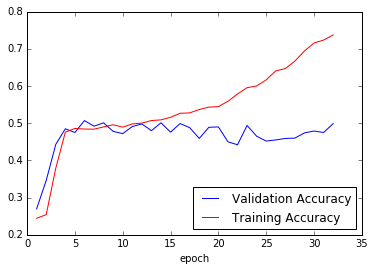

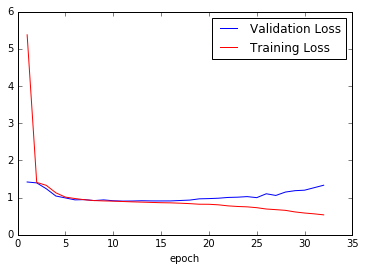

In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

log = h5py.File('Training_logs_DMN_plus.h5','r+') # Loading logs about change of training and validation loss and accuracy over epochs

y1 = log['val_acc'][...]
y2 = log['acc'][...]

x = np.arange(1,len(y1)+1,1) # (1 = starting epoch, len(y1) = no. of epochs, 1 = step) 

plt.plot(x,y1,'b',label='Validation Accuracy') 
plt.plot(x,y2,'r',label='Training Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.show()

y1 = log['val_loss'][...]
y2 = log['loss'][...]

plt.plot(x,y1,'b',label='Validation Loss')
plt.plot(x,y2,'r',label='Training Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.show()

In [16]:
with tf.Session() as sess: # Begin session
    
    print 'Loading pre-trained weights for the model...'
    saver = tf.train.Saver()
    saver.restore(sess, 'DMN_Model_Backup/model.ckpt')
    sess.run(tf.global_variables())
    print '\nRESTORATION COMPLETE\n'
    
    print 'Testing Model Performance...'
    
    total_test_loss = 0
    total_test_acc = 0
    
    test_batch_size = 100 #(should be able to divide total no. of test samples without remainder)
    batches_test_fact_stories,batches_test_questions,batches_test_answers = create_batches(test_fact_stories,test_questions,test_answers,test_batch_size)
        
    for i in xrange(len(batches_test_questions)):
        test_loss, test_acc = sess.run([cost, accuracy], 
                                        feed_dict={tf_facts: batches_test_fact_stories[i], 
                                                   tf_questions: batches_test_questions[i], 
                                                   tf_answers: batches_test_answers[i],
                                                   training: False})
        total_test_loss += test_loss
        total_test_acc += test_acc
                      
            
    avg_test_loss = total_test_loss/len(batches_test_questions) 
    avg_test_acc = total_test_acc/len(batches_test_questions) 


    print "\nTest Loss= " + \
          "{:.3f}".format(avg_test_loss) + ", Test Accuracy= " + \
          "{:.3f}%".format(avg_test_acc*100)+""


Loading pre-trained weights for the model...
INFO:tensorflow:Restoring parameters from DMN_Model_Backup/model.ckpt

RESTORATION COMPLETE

Testing Model Performance...

Test Loss= 0.941, Test Accuracy= 51.000%
